<a href="https://colab.research.google.com/github/dsubedi753/TORTOISE/blob/main/notebooks/DL_zero_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
GOOGLE_DRIVE_FOLDER = '/content/drive/MyDrive/GeoCompassSegmentations'

Mounted at /content/drive


In [ ]:
!pip install -e .

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 3.4 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=fe938487e9e51bc678d834b723f2ddaf5b5d76e959dbc4e170eaedd0e6adb365
  Stored in directory: /tmp/pip-ephem-wheel-cache-8q3m5z7k/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=0612a0b07f9cf38f6aa8f3189c9fd3235d4cf0dc02471a9beafa5c6cf141a3e2
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f

In [ ]:
# Install Dependencies
!pip install rasterio
!git clone https://github.com/facebookresearch/sam2.git
%cd ./sam2
!pip install -e .

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 12.83 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.1 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=7e6dcdaddb59c7ae1689efeee58addeb2f08bd103fb70b22027e3d39687d4b82
  Stored in directory: /tmp/pip-ephem-wheel-cache-x58gktkl/wheels/9e/fa

In [ ]:
# Import tortise data libraries
import sys
sys.path.append(GOOGLE_DRIVE_FOLDER + '/Colab_Notebooks/TORTOISE/src')

In [ ]:
# Unzip images into local machine (content directory)

!rm -rf '/content/data/tiles'
!mkdir '/content/data'
!cp "/content/drive/MyDrive/GeoCompassSegmentations/data/tile_index.csv" '/content/data/tile_index.csv'
!unzip -d '/content/data/' "/content/drive/MyDrive/GeoCompassSegmentations/data/tiles.zip"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/tiles/tile_rgb_06951.png.msk  
  inflating: /content/data/tiles/tile_rgb_01052.png.msk  
  inflating: /content/data/tiles/tile_rgb_03608.png.msk  
  inflating: /content/data/tiles/tile_label_02954.tif  
  inflating: /content/data/tiles/tile_label_11130.tif  
  inflating: /content/data/tiles/tile_rgb_01253.png.aux.xml  
  inflating: /content/data/tiles/tile_ms_14106.tif  
 extracting: /content/data/tiles/tile_rgb_05773.png  
  inflating: /content/data/tiles/tile_label_14018.tif  
  inflating: /content/data/tiles/tile_rgb_10797.png.msk  
  inflating: /content/data/tiles/tile_ms_03295.tif  
  inflating: /content/data/tiles/tile_rgb_10954.png.msk  
  inflating: /content/data/tiles/tile_rgb_09938.png.msk  
  inflating: /content/data/tiles/tile_label_10017.tif  
 extracting: /content/data/tiles/tile_rgb_05017.png  
  inflating: /content/data/tiles/tile_label_08049.tif  
 extracting: /content/data/tiles/tile_rgb_086

In [ ]:
from tortoise.dataloader import build_dataloaders

BATCH_SIZE = 16

train_loader, val_loader, test_loader, image_index = build_dataloaders(
    "/content/data/tiles",
    '/content/data/tile_index.csv',
    BATCH_SIZE,
    seed = 42,
    train_ratio = 0.8,
    val_ratio = 0.1,
    test_ratio = None,
    use_rgb=  True,
    use_ms=False,
    num_workers = 0,
)

In [ ]:
import torch
import torch.nn.functional as F
import os
import numpy as np
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
sam2_checkpoint = "/sam2.1_hiera_small.pt"
url = "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

device = 'cuda'

if not os.path.exists(sam2_checkpoint):
  !wget {url} -O {sam2_checkpoint}

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
FINETUNE = True
if FINETUNE:
    finetuned = GOOGLE_DRIVE_FOLDER + "/Colab_Notebooks/models/SAM_model_96_px_cp_3.pth"
    state = torch.load(finetuned, map_location="cpu")
    sam2_model.load_state_dict(state, strict=False)
predictor = SAM2ImagePredictor(sam2_model)

--2025-12-11 03:47:19--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.121, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘/sam2.1_hiera_small.pt’

/sam2.1_hiera_small 100%[===================>] 175.87M   241MB/s    in 0.7s    

2025-12-11 03:47:20 (241 MB/s) - ‘/sam2.1_hiera_small.pt’ saved [184416285/184416285]



In [ ]:
def calculate_bce_dice_metric(pred_logit, gt_mask, valid_mask):
  pred_logit *= valid_mask
  # convert to tensor
  pred_tensor = torch.from_numpy(pred_logit).float().unsqueeze(0)
  gt_tensor = torch.from_numpy(gt_mask).float().unsqueeze(0)

  # bce score
  bce = F.binary_cross_entropy_with_logits(pred_tensor, gt_tensor).item()

  # dice score
  pred_probs = torch.sigmoid(pred_tensor)
  smooth = 1e-6
  intersection = (pred_probs * gt_tensor).sum()
  dice_score = (2.0 * intersection + smooth) / (pred_probs.sum() + gt_tensor.sum() + smooth)
  dice_val = dice_score.item()

  # dice loss (1-dice score)
  dice_loss = 1 - dice_score

  # combine
  combined_loss = bce + dice_loss

  return bce, dice_loss, combined_loss

In [ ]:
def calculate_iou(pred_labels, gt_labels, valid_mask):
  # cal IOU between predicted actual mask
  pred_labels *= valid_mask
  pred_flat = pred_labels.flatten().astype(bool)
  gt_flat = gt_labels.flatten().astype(bool)

  intersection = np.logical_and(pred_flat, gt_flat).sum()
  union = np.logical_or(pred_flat, gt_flat).sum()

  if union == 0:
    if intersection == 0:
      return 0
    else:
      return 1
  return intersection / union

def _binary_boundary(mask: torch.Tensor, dilation_pixel=2):
    """
    Extract thin binary boundary from a binary mask using Laplacian.
    mask: (H, W) binary {0,1}
    """
    dilation = dilation_pixel

    lap = torch.tensor([[0, 1, 0],
                        [1,-4, 1],
                        [0, 1, 0]], dtype=torch.float32, device=mask.device).unsqueeze(0).unsqueeze(0)

    # Find boundary pixels
    mask_f = mask.float().unsqueeze(0).unsqueeze(0)
    edges = F.conv2d(mask_f, lap, padding=1).abs()
    edges = (edges > 0).float().squeeze()

    # Dilate boundary
    if dilation > 1:
        kernel = torch.ones((1,1,dilation,dilation), device=mask.device)
        edges = edges.unsqueeze(0).unsqueeze(0)
        dil = F.conv2d(edges, kernel, padding=dilation//2)
        dil = (dil > 0).float().squeeze()
        return dil
    else:
        return edges
def evaluate_metrics(
    logits,
    labels,
    mask,
    metrics=["iou", "dice", "brier"],
    threshold=0.5,
):
    out = {}
    logits = logits.float()
    labels = labels.float()
    mask = mask.float()

    valid = (mask > 0)

    probs = torch.sigmoid(logits)
    probs_valid = probs[valid]
    labels_valid = labels[valid]

    if any(m in metrics for m in ["iou","dice","precision","recall","fpr","fnr"]):
        pred_bin = (probs > threshold)
        label_bin = (labels > 0.5)

        pred_bin = pred_bin & valid
        label_bin = label_bin & valid

        TP = (pred_bin & label_bin).sum().float()
        FP = (pred_bin & ~label_bin).sum().float()
        FN = (~pred_bin & label_bin).sum().float()
        TN = (~pred_bin & ~label_bin & valid).sum().float()

        if "iou" in metrics:
            out["iou"] = (TP / (TP + FP + FN + 1e-6)).item()

        if "dice" in metrics:
            out["dice"] = (2 * TP / (2 * TP + FP + FN + 1e-6)).item()

        if "precision" in metrics:
            out["precision"] = (TP / (TP + FP + 1e-6)).item()

        if "recall" in metrics:
            out["recall"] = (TP / (TP + FN + 1e-6)).item()

        if "fpr" in metrics:
            out["fpr"] = (FP / (FP + TN + 1e-6)).item()

        if "fnr" in metrics:
            out["fnr"] = (FN / (FN + TP + 1e-6)).item()

    if "brier" in metrics:
        out["brier"] = ((probs_valid - labels_valid)**2).mean().item()

    if "pixelwise_entropy" in metrics:
        p = probs.clamp(1e-6, 1 - 1e-6)
        entropy = -(p * torch.log(p) + (1 - p) * torch.log(1 - p))
        out["pixelwise_entropy"] = entropy * mask

    if "boundary_iou" in metrics:
        pred_bin = (probs > threshold) & valid
        label_bin = (labels > 0.5) & valid

        # boundary extraction
        b_pred = _binary_boundary(pred_bin.float())
        b_label = _binary_boundary(label_bin.float())

        # intersection and union
        inter = (b_pred * b_label).sum().float()
        union = (b_pred + b_label).clamp(max=1).sum().float()

        out["boundary_iou"] = (inter / (union + 1e-6)).item()

    return out

import pandas as pd

def get_bounding_box(mask):

  rows, cols = np.where(mask>0)
  if len(rows) == 0:
        return None
  return np.array([np.min(cols), np.min(rows), np.max(cols), np.max(rows)])

def evaluate_sam2(loader, predictor, max_examples=None):

    metrics_list = []
    pred_area = 0
    true_area = 0
    area_ratio = 0

    # Iterate through batches
    test_image_numbers = image_index[2]
    for image_number in test_image_numbers:
        batch_data = loader[image_number]
        # Adjust unpacking based on your dataloader structure
        images = batch_data['rgb']
        gt_masks = batch_data['label']
        valid_masks = batch_data['mask']

        # A. Preprocess Image (C,H,W -> H,W,C and uint8 0-255)
        img_np = images.transpose(1, 2, 0)

        # Denormalize if necessary
        if img_np.max() <= 1.0:
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)

        predictor.set_image(img_np)

        # B. Prepare Prompt
        gt_mask_np = gt_masks.cpu().numpy()
        if gt_mask_np.ndim == 3:
            gt_mask_np = gt_mask_np[0]

        valid_mask_np = valid_masks.cpu().numpy().astype(np.uint8)

        gt_mask_np = (gt_mask_np > 0).astype(np.uint8)
        box_prompt = get_bounding_box(gt_mask_np)

        if box_prompt is None:
            continue

        # C. Predict
        masks, scores, _ = predictor.predict(
            box=box_prompt,
            multimask_output=True
        )

        # D. Calculate IoU
        best_idx = np.argmax(scores)
        pred_mask = (masks[best_idx] > 0.0).astype(np.uint8)
        m = evaluate_metrics(
            logits=torch.from_numpy(pred_mask),
            labels=torch.from_numpy(gt_mask_np),
            mask=valid_masks,
            metrics=["iou","dice","precision","recall","fpr","fnr"],
        )
        m['pred_labels'] = torch.sigmoid(torch.from_numpy(pred_mask)).numpy()

        pred_area += (m['pred_labels']*(valid_mask_np) > 0.5).sum()
        true_area += (gt_mask_np > 0.5).sum()
        metrics_list.append(m)
        print(m["iou"])

    area_ratio = pred_area/true_area
    return metrics_list, area_ratio


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(values, metric_name='score', color='blue'):

  plt.figure(figsize=(12, 5))

  # histogram w/ kde
  plt.subplot(1,2,1)
  sns.histplot(values, kde=True, bins=30, color=color, alpha=0.6)
  mean_val = np.mean(values)
  plt.axvline(mean_val, color='red', linestyle='--', label=f"mean:{mean_val:.2f}")
  plt.title(f'Distribution for {metric_name}')
  plt.xlabel(f'{metric_name} value')
  plt.ylabel('count')
  plt.legend()

  # box plot
  plt.subplot(1,2,2)
  sns.boxplot(x=values, color=color)
  plt.title(f'box plot for {metric_name}')
  plt.xlabel(f'{metric_name} score')

  plt.tight_layout()
  plt.show()

In [ ]:
# Now we make a custom dataloader for images on disk
import rasterio
from torch.utils.data import Dataset
class FullImageDataset(Dataset):
    def __init__(self, imageset_dir):
        self.imageset_dir = imageset_dir
        return

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, image_id):
        res = dict()
        image_id_dir = self.imageset_dir + "/" + image_id
        with rasterio.open(image_id_dir + "/label.tif") as src:
            label_full = torch.from_numpy(src.read(1).astype(np.float32)) / 65535.0
            label_mask = torch.from_numpy(src.dataset_mask().astype(np.float32)) / 255.0
        with rasterio.open(image_id_dir + "/rgb.png") as src:
            arr = src.read().astype(np.float32) / 255.0
        res['rgb'] = arr
        res['label'] = label_full
        res['mask'] = label_mask
        return res

In [ ]:
full_image_loader = FullImageDataset(GOOGLE_DRIVE_FOLDER + "/data-96-rgb/imageset")
# I changed this to evaluate our models on full images - Michael
metrics_list, area_ratio = evaluate_sam2(full_image_loader, predictor)
print(area_ratio)


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


0.6680299639701843
0.4812640845775604
0.5943060517311096
0.5671337246894836
0.7178294658660889
0.5343721508979797
0.5839999914169312
0.6931266784667969
0.8799999952316284
0.7895181775093079
0.48218029737472534
0.921225368976593
0.7126246094703674
0.8186274766921997
0.7951807379722595
0.6085737347602844
0.49293285608291626
0.5765765905380249
0.6800000071525574
0.843967854976654
0.6942148804664612
0.6104877591133118
0.8112927079200745
0.5735599398612976
0.557611882686615
0.9087003469467163
0.7981462478637695
0.7949029207229614
0.720293402671814
0.7143529653549194
0.5254592299461365
0.6335476040840149
0.5422794222831726
0.8079096078872681
0.5022488832473755
0.30203181505203247
0.5439469218254089
0.7324894666671753
0.305912584066391
0.8335343599319458
0.6398276686668396
0.8419243693351746
0.5251172184944153
0.8727810382843018
0.7042685747146606
0.4893360137939453
0.7488707900047302
0.2570694088935852
0.8413823843002319
0.4545454680919647
0.7247706651687622
0.9464727640151978
0.701576590538

243


/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


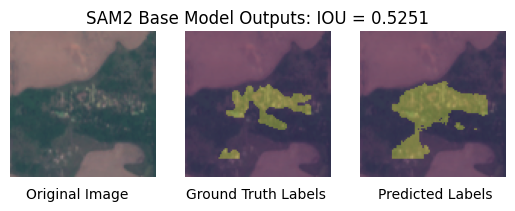

In [ ]:
df = pd.DataFrame(metrics_list, index=image_index[2])
def get_images_at_index(image_id):
    imageset_dir = GOOGLE_DRIVE_FOLDER + "/data-96-rgb/imageset"
    print(image_id)
    image_id_dir = imageset_dir +"/" + image_id
    res =  full_image_loader[image_id]
    rgb = res['rgb']
    label_full = res['label']
    label_mask = res['mask']
    return rgb, label_full, label_mask
low_quantile = df['iou'][df['iou'] == df['iou'].quantile(.24, interpolation='nearest')].index.item()
mid_quantile = df['iou'][df['iou'] == df['iou'].quantile(.5, interpolation='nearest')].index.item()
high_quantile = df['iou'][df['iou'] == df['iou'].quantile(1, interpolation='nearest')].index.item()

quantile_to_plot = low_quantile

rgb, label, mask = get_images_at_index(quantile_to_plot)
iou = df.loc[quantile_to_plot]['iou']
rgb = rgb.transpose(1,2,0)
label = label*mask
pred_label = df.loc[quantile_to_plot]['pred_labels']*mask.numpy() > 0.5

fix, axs = plt.subplots(1, 3,)
# Show original image
axs[0].imshow(rgb)
# Then image with ground truth
axs[1].imshow(rgb)
axs[1].imshow(label, alpha=0.3)
# Then final image
axs[2].imshow(rgb)
axs[2].imshow(pred_label, alpha=0.3)
axs[0].axis("off")
axs[1].axis("off")
axs[2].axis("off")
plt.figtext(0.15, 0.3, "Original Image", wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.4, 0.3, "Ground Truth Labels", wrap=True, horizontalalignment='left', fontsize=10)
plt.figtext(0.7, 0.3, "Predicted Labels", wrap=True, horizontalalignment='left', fontsize=10)
axs[1].set_title(f"SAM2 Base Model Outputs: IOU = {iou:.04f}", loc='center')
plt.show()

576
72
72
92


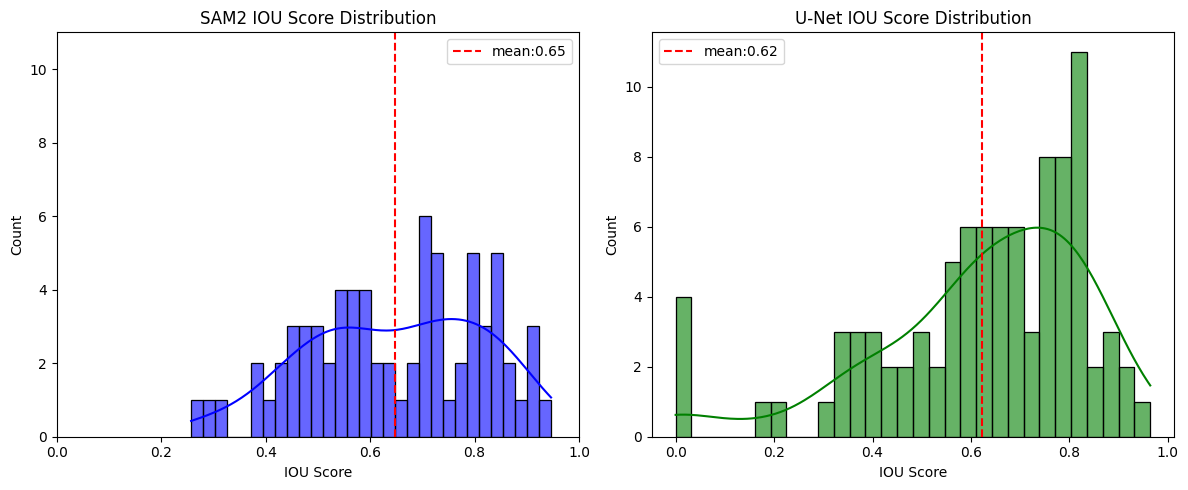

In [ ]:
plt.figure(figsize=(12, 5))
metric_name = 'IOU Score'
# histogram w/ kde
plt.subplot(1,2,1)
sns.histplot(df['iou'], kde=True, bins=30, color="blue", alpha=0.6)
mean_val = np.mean(df['iou'])
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean:{mean_val:.2f}")
plt.title(f'SAM2 {metric_name} Distribution')
plt.xlabel(f'{metric_name}')
plt.xlim(left=0)
plt.xlim(right=1)
plt.ylim(top=11)
plt.ylabel('Count')
plt.legend()

# Values for U-Net
values = [0.7871286869049072,
 0.62628573179245,
 0.0,
 0.7284740209579468,
 0.3879365026950836,
 0.8785194754600525,
 0.49933066964149475,
 0.8096479773521423,
 0.5441967844963074,
 0.8117647171020508,
 0.5600649118423462,
 0.755751371383667,
 0.8296913504600525,
 0.3029850721359253,
 0.6847290396690369,
 0.19674038887023926,
 0.5802229642868042,
 0.5741461515426636,
 0.7966321110725403,
 0.7508805394172668,
 0.47289156913757324,
 0.9045225977897644,
 0.7615324258804321,
 0.43921568989753723,
 0.3443526029586792,
 0.6509959101676941,
 0.39428141713142395,
 0.6122449040412903,
 0.8184532523155212,
 0.807947039604187,
 0.669205367565155,
 0.8335700631141663,
 0.8205645084381104,
 0.4165571630001068,
 0.8283752799034119,
 0.3383512496948242,
 0.8667469620704651,
 0.16113458573818207,
 0.875,
 0.753731369972229,
 0.7890961170196533,
 0.6428571343421936,
 0.7904762029647827,
 0.0,
 0.7756756544113159,
 0.8281938433647156,
 0.6619216799736023,
 0.6927881836891174,
 0.682539701461792,
 0.6886701583862305,
 0.49695122241973877,
 0.6334080696105957,
 0.9642627239227295,
 0.5006135106086731,
 0.5541401505470276,
 0.6519666314125061,
 0.6074073910713196,
 0.7627329230308533,
 0.5848101377487183,
 0.6035665273666382,
 0.5290580987930298,
 0.36883941292762756,
 0.8241451382637024,
 0.7085307836532593,
 0.7845386266708374,
 0.8500640392303467,
 0.7404255270957947,
 0.6612493395805359,
 0.6355498433113098,
 0.5691668391227722,
 0.321856290102005,
 0.7649681568145752,
 0.6102418303489685,
 0.6882951855659485,
 0.0,
 0.7817679643630981,
 0.5654334425926208,
 0.36316871643066406,
 0.7723880410194397,
 0.6182472705841064,
 0.7504985332489014,
 0.4540059268474579,
 0.8258630037307739,
 0.9294294118881226,
 0.44891640543937683,
 0.6781429052352905,
 0.37529975175857544,
 0.6275020241737366,
 0.6024355292320251,
 0.7260273694992065,
 0.8707724809646606,
 0.0]

print(len(image_index[0]))
print(len(image_index[1]))
print(len(image_index[2]))
print(len(values))
# box plot
plt.subplot(1,2,2)
sns.histplot(values, kde=True, bins=30, color="green", alpha=0.6)
mean_val = np.mean(values)
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean:{mean_val:.2f}")
plt.title(f'U-Net {metric_name} Distribution')
plt.xlabel(f'{metric_name}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plot_metrics(df['iou'], metric_name="IoU Score", color='blue')

NameError: name 'df' is not defined

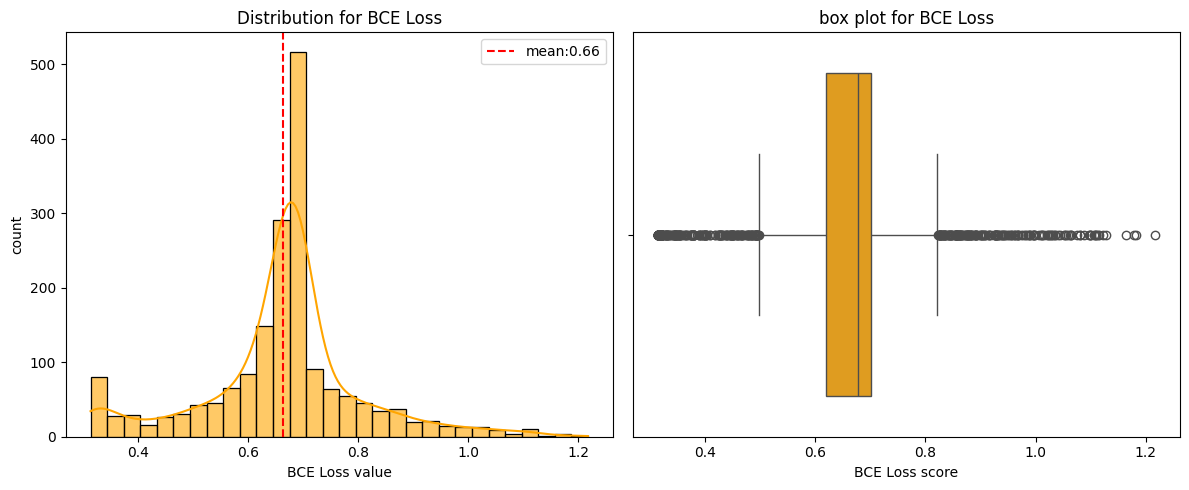

In [ ]:
plot_metrics(test_bce, metric_name="BCE Loss", color='orange')

ValueError: `dataset` input should have multiple elements.

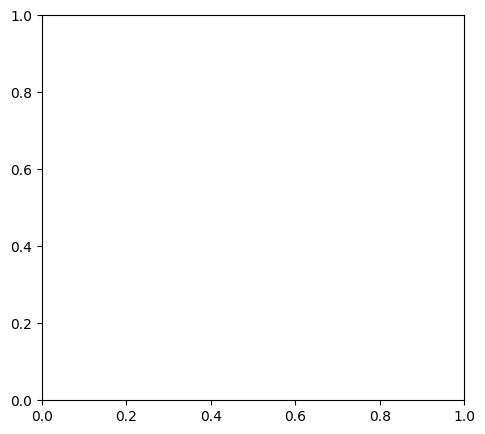

In [ ]:
plot_metrics(test_dice, metric_name="Dice Loss", color='green')